In [1]:
import pandas as pd
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import datetime
import pandas as pd
from sklearn import preprocessing
import fbprophet
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

## 1. Create required number years (x axis)

In [2]:
x_axis_data = np.arange(2009,2046,step=1)
x_axis_data

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045])

## 2. Solar Consumption

In [3]:
# Load data
solar_consumption = pd.read_csv('../data/modern-renewable-energy-consumption.csv')
solar_consumption = solar_consumption[solar_consumption['Entity']=='World'][['Year', 'Solar (terawatt-hours)']]
# Only take section fromn 1990, as before that it was essentially zero
solar_consumption = solar_consumption.copy().iloc[25:]

In [41]:
solar_consumption

,Year,Solar (terawatt-hours)
4149,1990,0.386563
4150,1991,0.506460
4151,1992,0.468813
4152,1993,0.556796
4153,1994,0.600992
4154,1995,0.641600
4155,1996,0.704925
4156,1997,0.757072
4157,1998,0.879725
4158,1999,0.964557


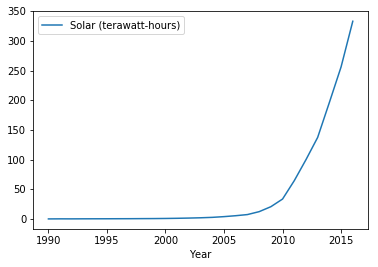

In [4]:
solar_consumption.plot(x='Year', y='Solar (terawatt-hours)')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.0.


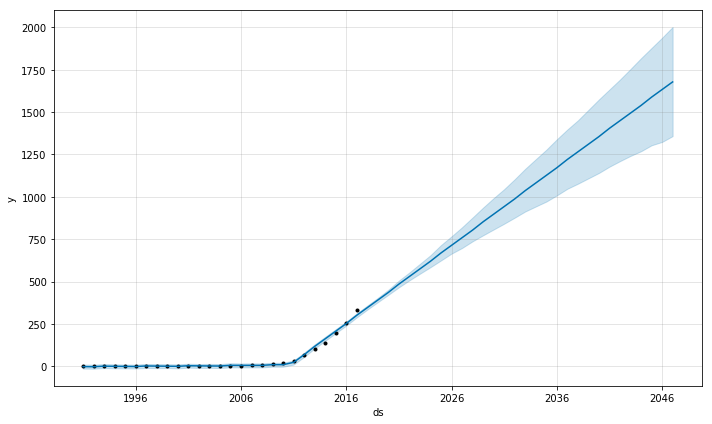

In [53]:
# Prophet model
# Create dataframe (Prophet needs columns 'ds' and 'y')
fc_consumption = pd.DataFrame(columns=['ds','y'])
fc_consumption['ds'] = solar_consumption['Year'].values
fc_consumption['ds']  = fc_consumption['ds'].apply(lambda d: datetime.datetime.strptime(f'{str(d)}-12-31', "%Y-%m-%d")) 
fc_consumption['y'] = solar_consumption['Solar (terawatt-hours)'].values

# Create Prophet model
model_consumption = fbprophet.Prophet(changepoint_prior_scale=0.15)
model_consumption.fit(fc_consumption)

# Create dataframe to hold forecasted values
future_df_consumption = model_consumption.make_future_dataframe(periods=30, freq='y')

# Forecast using Prophet model, and plot
forecast_consumption = model_consumption.predict(future_df_consumption)
model_consumption.plot(forecast_consumption);

In [57]:
# Get wanted bounds - 2009 o 2045
cons_fc_df = forecast_consumption[['ds', 'yhat']]
cons_fc_df['ds'] = cons_fc_df['ds'].apply(lambda d: d.year)
cons_fc_df = cons_fc_df[(cons_fc_df['ds'] > 2008) & (cons_fc_df['ds'] < 2046)]

In [58]:
cons_fc_df['yhat'] = min_max_scaler.fit_transform(np.array(cons_fc_df['yhat']).reshape(-1,1))

In [59]:
cons_fc_df

,ds,yhat
19,2009,0.000000
20,2010,0.008493
21,2011,0.036199
22,2012,0.066431
23,2013,0.094066
24,2014,0.121735
25,2015,0.149441
26,2016,0.179673
27,2017,0.207307
28,2018,0.234977


## 3. Solar Loadings (Thrifting)

In [60]:
## Read in data (include 2028 Silver Institute 'predicted' entry)
est_thrifting = pd.read_excel('../data/silver_solar_thrifting_estimates.xlsx')

In [61]:
# Normalize/scale 
# Normalize both Estimated Silver loadings and Solar Consumption
min_max_scaler = preprocessing.MinMaxScaler()
thrifting_scaled = min_max_scaler.fit_transform(est_thrifting)

scaled_thrifting_df = pd.DataFrame(columns=['Year', 'Silver Loadings (Scaled)'], data=thrifting_scaled)

/Users/pst-home/anaconda3/envs/data_science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



/Users/pst-home/anaconda3/envs/data_science/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



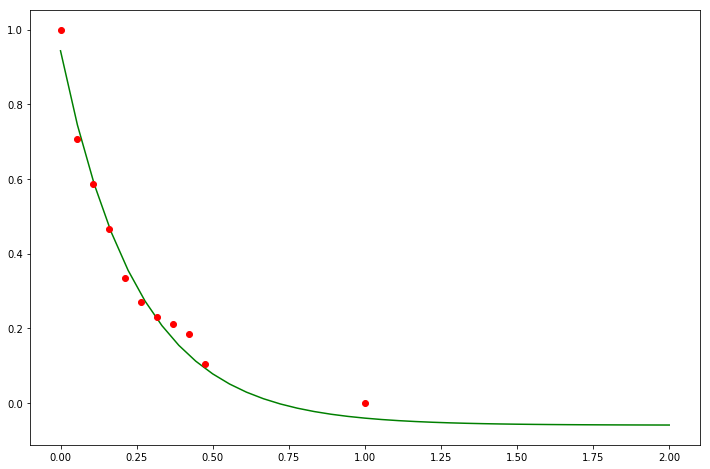

In [62]:
# Fit Exponential Curve
xdata = scaled_thrifting_df['Year'].values
ydata = scaled_thrifting_df['Silver Loadings (Scaled)'].values
x = np.array(xdata)
y = np.array(ydata)

def f(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = optimize.curve_fit(f,x,y, bounds=([0,0,-0.15], [10,10, -0.06]))
# popt, pcov = optimize.curve_fit(f,x,y)
x1 = np.linspace(0,2,num =37)
x2 = min_max_scaler.fit_transform(x_axis_data.reshape(-1, 1))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.plot(x1, f(x1, *popt), 'g',)
plt.plot(x,y,'ro')
plt.show()

In [63]:
fitted = pd.DataFrame([x1, f(x1, *popt)]).T
pd.DataFrame(min_max_scaler.inverse_transform(fitted)).sort_values(by=0)

,0,1
0,2009.0,2042.962774
1,2011.0,2035.804534
2,2013.0,2030.064801
3,2015.0,2025.462477
4,2017.0,2021.772169
5,2019.0,2018.813148
6,2021.0,2016.440499
7,2023.0,2014.538024
8,2025.0,2013.012551
9,2027.0,2011.789373


In [64]:
thrift_fc_df = pd.DataFrame(columns=['ds', 'yhat'])
thrift_fc_df['ds'] = x_axis_data
thrift_fc_df['yhat'] = f(x1, *popt)

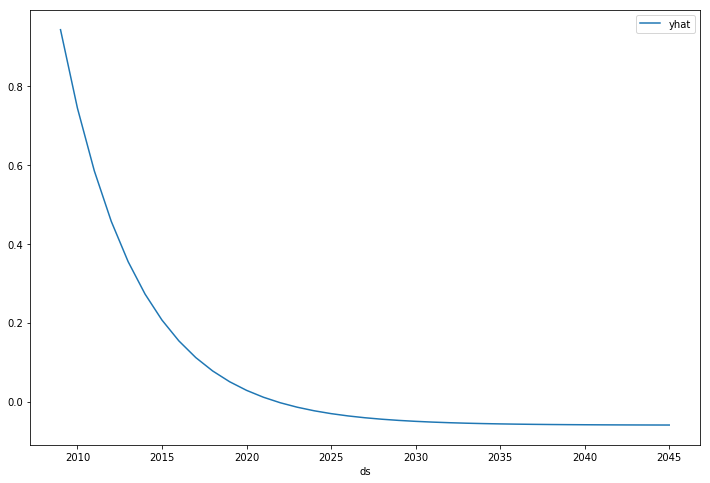

In [65]:
thrift_fc_df.plot(x='ds', y='yhat')

In [66]:
thrift_fc_df

,ds,yhat
0,2009,0.943410
1,2010,0.744570
2,2011,0.585133
3,2012,0.457291
4,2013,0.354782
5,2014,0.272587
6,2015,0.206681
7,2016,0.153834
8,2017,0.111460
9,2018,0.077483


In [67]:
cons_fc_df

,ds,yhat
19,2009,0.000000
20,2010,0.008493
21,2011,0.036199
22,2012,0.066431
23,2013,0.094066
24,2014,0.121735
25,2015,0.149441
26,2016,0.179673
27,2017,0.207307
28,2018,0.234977


In [68]:
df_final = pd.DataFrame(columns=['Year', 'Normalized Solar Consumption', 'Normalized Silver Loadings'])
df_final['Year'] = x_axis_data
df_final['Normalized Solar Consumption'] = cons_fc_df.reset_index()['yhat']

# min_max_scaler.fit_transform(np.array(cons_fc_df.reset_index()['yhat']).reshape(-1,1))
df_final['Normalized Silver Loadings'] = \
min_max_scaler.fit_transform(np.array(thrift_fc_df.reset_index()['yhat']).reshape(-1,1))

In [69]:
df_final['Normalized Solar Consumption'] = min_max_scaler.fit_transform(np.array(df_final['Normalized Solar Consumption']).reshape(-1,1))

In [70]:
min_max_scaler.fit_transform(np.array(df_final['Normalized Solar Consumption']).reshape(-1,1))

array([[0.        ],
       [0.00849349],
       [0.03619912],
       [0.06643147],
       [0.09406571],
       [0.12173527],
       [0.14944091],
       [0.17967325],
       [0.2073075 ],
       [0.23497706],
       [0.26268269],
       [0.29291504],
       [0.32054928],
       [0.34821884],
       [0.37592448],
       [0.40615683],
       [0.43379107],
       [0.46146063],
       [0.48916627],
       [0.51939861],
       [0.54703286],
       [0.57470242],
       [0.60240805],
       [0.6326404 ],
       [0.66027464],
       [0.6879442 ],
       [0.71564984],
       [0.74588219],
       [0.77351643],
       [0.80118599],
       [0.82889163],
       [0.85912397],
       [0.88675821],
       [0.91442778],
       [0.94213341],
       [0.97236576],
       [1.        ]])

In [71]:
len(min_max_scaler.fit_transform(np.array(cons_fc_df.reset_index()['yhat']).reshape(-1,1)))

37

In [72]:
thrift_fc_df.reset_index()

,index,ds,yhat
0,0,2009,0.943410
1,1,2010,0.744570
2,2,2011,0.585133
3,3,2012,0.457291
4,4,2013,0.354782
5,5,2014,0.272587
6,6,2015,0.206681
7,7,2016,0.153834
8,8,2017,0.111460
9,9,2018,0.077483


In [73]:
cons_fc_df.reset_index()

,index,ds,yhat
0,19,2009,0.000000
1,20,2010,0.008493
2,21,2011,0.036199
3,22,2012,0.066431
4,23,2013,0.094066
5,24,2014,0.121735
6,25,2015,0.149441
7,26,2016,0.179673
8,27,2017,0.207307
9,28,2018,0.234977


In [74]:
df_final['Normalized Solar Consumption'] +=1
df_final['Normalized Silver Loadings'] +=1

In [75]:
df_final.head()

,Year,Normalized Solar Consumption,Normalized Silver Loadings
0,2009,1.000000,2.000000
1,2010,1.008493,1.801766
2,2011,1.036199,1.642815
3,2012,1.066431,1.515362
4,2013,1.094066,1.413166


In [76]:
df_final['Combination'] = df_final['Normalized Solar Consumption']*df_final['Normalized Silver Loadings']

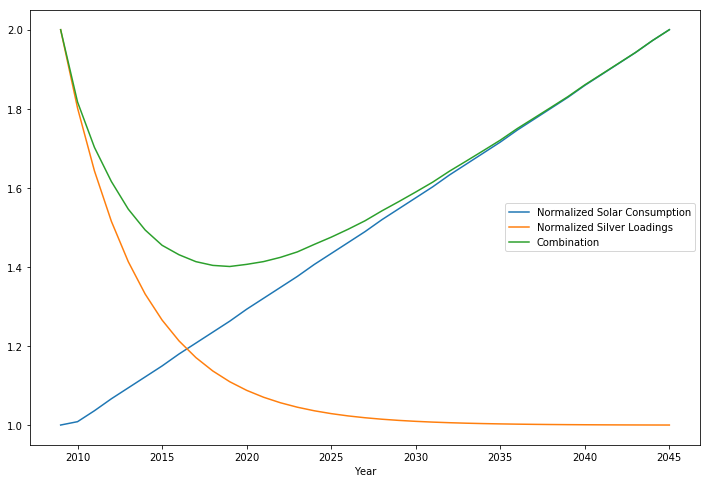

In [77]:
df_final.plot(x='Year', y=['Normalized Solar Consumption', 'Normalized Silver Loadings', 'Combination'])

In [78]:
df_final.set_index('Year')[['Normalized Solar Consumption', 'Normalized Silver Loadings', 'Combination']]\
.iplot(kind='line', xTitle='Year', 
                  yTitle='Normalized Score (1-2)', 
       title='Solar Demand Forecast Using Silver Loading/cell & Solar (TWh) Consumption Forecasts', width=4)

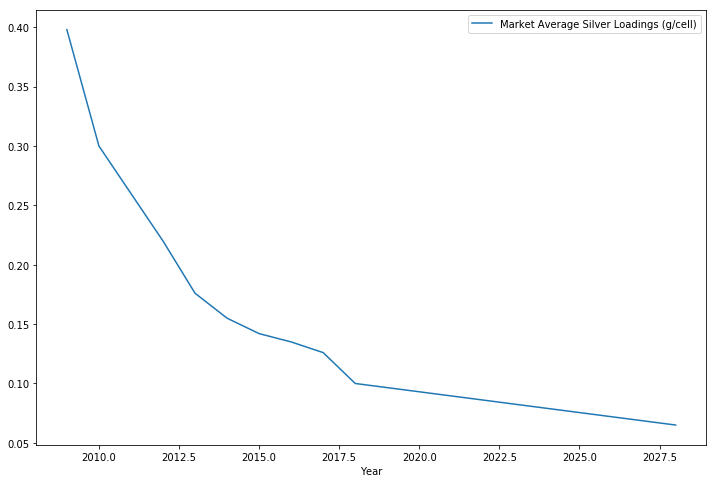

In [79]:
est_thrifting.plot(x='Year', y='Market Average Silver Loadings (g/cell)')